# **Potato Disease Classification with PlantVillage dataset**

## **Project by:** Aarish & Asif Khan

## **Date:** 24th April 2024

##  **Dataset:** [PlantVillage data](https://www.kaggle.com/datasets/arjuntejaswi/plant-village)

---

In this endeavor, we aim to categorize the various diseases affecting potato crops. This notebook promises to be an invaluable resource!

---

# **Notebook Contents:**

1. Data Collection
2. Data Pre-processing
3. Creating a model
4. Presenting the model
5. Perform Quantization for making the model size smaller
6. Tensorflow Serving
7. Uploading the model on Google cloud

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models, layers

C:\Users\nawaz\AppData\Local\Temp\ipykernel_2020\3334143220.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [27]:
# Defining Constants
width = 256
height = 256

size = 256
batch_size = 32

channels = 3
epochs = 50

In [3]:
# Data Dir
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(size, size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
# Check classes 
data_classes = data.class_names
print("Classes in our Dataset:", data_classes) 

Classes in our Dataset: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


We have three classes in our main directory. Early blight, late blight and healthy!

In [5]:
data_len = len(data)
print("Length of data:", data_len)

Length of data: 68


The reason that we are getting the length 68 is because our images our stored in batches. So if you multiply 68 with 32 you'll get the exact answer not exact but close to the actual answer.

In [6]:
68 * 32

2176

In [7]:
for image_batch, label_batch in data.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


In [8]:
for image_batch, label_batch in data.take(1):
    print(image_batch[0].numpy())

[[[151. 148. 157.]
  [180. 177. 186.]
  [169. 166. 175.]
  ...
  [184. 182. 193.]
  [184. 182. 193.]
  [186. 184. 195.]]

 [[170. 167. 176.]
  [153. 150. 159.]
  [162. 159. 168.]
  ...
  [187. 185. 196.]
  [185. 183. 194.]
  [186. 184. 195.]]

 [[157. 154. 163.]
  [178. 175. 184.]
  [186. 183. 192.]
  ...
  [188. 186. 197.]
  [187. 185. 196.]
  [187. 185. 196.]]

 ...

 [[129. 130. 148.]
  [142. 143. 161.]
  [145. 146. 164.]
  ...
  [157. 158. 179.]
  [157. 158. 179.]
  [160. 161. 182.]]

 [[142. 143. 161.]
  [156. 157. 175.]
  [141. 142. 160.]
  ...
  [153. 154. 175.]
  [153. 154. 175.]
  [157. 158. 179.]]

 [[134. 135. 153.]
  [160. 161. 179.]
  [152. 153. 171.]
  ...
  [155. 156. 177.]
  [155. 156. 177.]
  [159. 160. 181.]]]


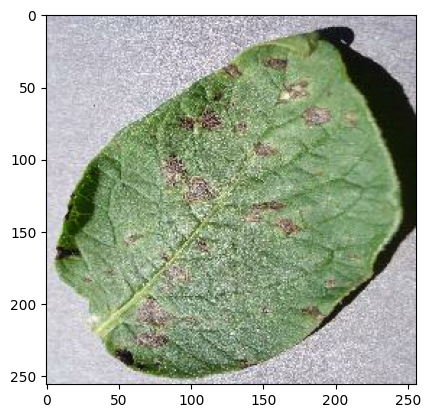

In [9]:
for image_batch, label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

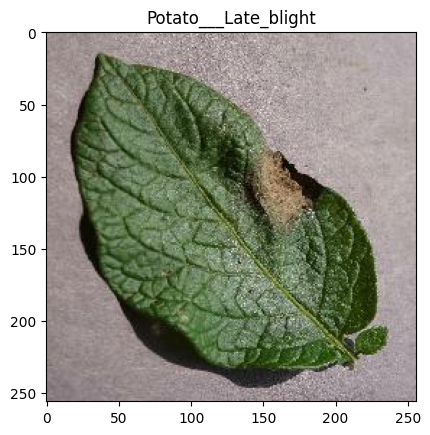

In [10]:
for image_batch, label_batch in data.take(1):
    plt.title(data_classes[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

The images are shuffling every time you run the code, that is because we enabled shuffling=True.

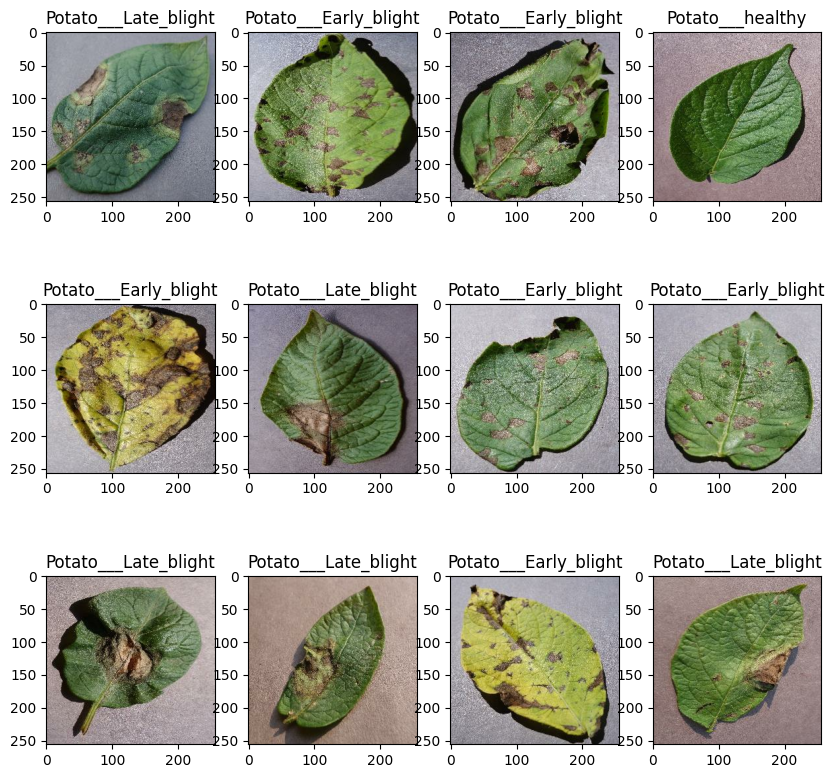

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(data_classes[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))

In [12]:
training_size = 0.8
len(data) * training_size

54.400000000000006

In [13]:
training_ds = data.take(54)
len(training_ds)

54

In [14]:
testing_ds = data.skip(54)
len(testing_ds)

14

In [15]:
val_size = 0.1
len(data) * val_size

6.800000000000001

In [16]:
val_ds = data.take(6)
len(val_ds)

6

In [17]:
testing_ds = testing_ds.skip(6)
len(testing_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(data) 

In [19]:
# Cache and prefetch the data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Layer for normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(size, size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# Define input shape and classes
input_shape = (batch_size, size, size, channels)
n_classes = 3

In [25]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 243s 4s/step - loss: 0.9148 - accuracy: 0.4983 - val_loss: 0.8922 - val_accuracy: 0.5208
Epoch 2/50
54/54 [==============================] - 291s 5s/step - loss: 0.7374 - accuracy: 0.6406 - val_loss: 0.5085 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 295s 5s/step - loss: 0.4605 - accuracy: 0.8044 - val_loss: 0.4975 - val_accuracy: 0.7552
Epoch 4/50
51/54 [===========================>..] - ETA: 16s - loss: 0.3278 - accuracy: 0.8634

In [ ]:
# Evaluate the results on the testing data
output_results = model.evaluate(test_ds)

In [ ]:
output_results # You will get the results in a numpy array

In [ ]:
history

In [ ]:
# Check parameters
history.params

In [ ]:
history.history.keys() # Keys include loss, accuracy, val_loss, val_accuracy

In [ ]:
# You can check dtypes of the keys
type(history.history['loss'])

In [ ]:
epochs_len = len(history.history['loss'])
print(epochs_len)

In [ ]:
history.history['accuracy'][:10]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training of Epochs | Train & Val accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Train Loss')
plt.plot(range(epochs), val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training of Epochs | Train & Val loss)
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Image to predict:")
    plt.imshow(first_image)
    print("The actual Label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("The predicted Label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../aarish_and_asif's_model.h5")